In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import cv2

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

master_path = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터2] samp_train'}.csv")
master = pd.read_csv(master_path)
master.MRC_ID_DI[master.MRC_ID_DI > 0 ] = 1

In [4]:
master_0 = master[master['MRC_ID_DI'] == 0].sample(frac=1)
master_1 = master[master['MRC_ID_DI'] == 1].sample(frac=1)

sample_size = len(master_0) if len(master_0) < len(master_1) else len(master_1)

master = pd.concat([master_0.head(sample_size), master_1.head(sample_size)]).sample(frac=1)

master_copy = master.copy()
train_set = master_copy.sample(frac=0.9, random_state=42)
test_set = master_copy.drop(train_set.index)

In [5]:
img_path = os.path.join(os.getcwd(), 'image')

y = []
X_paths = []

for i in range(len(master)):
    if master.iloc[i, 0] in train_set.cst_id_di.values:
        X_paths.append( os.path.join(img_path, str(master.iloc[i, 0]) +'.png') )
        y.append(master.iloc[i, 1])

y = np.array(y)
y = tf.keras.utils.to_categorical(y)

X_train_paths, X_test_paths, y_train, y_test = train_test_split(X_paths, y, test_size=0.1, random_state=1)

X_train_paths, X_val_paths, y_train, y_val = train_test_split(X_train_paths, y_train, test_size=0.1, random_state=1)

In [6]:
X_train = []
for file_path in X_train_paths:
    #read image
    img = cv2.imread(file_path)
    X_train.append(img)

X_train = np.array(X_train)

X_val = []
for file_path in X_val_paths:
    #read image
    img = cv2.imread(file_path)
    X_val.append(img)

X_val = np.array(X_val)

X_test = []
for file_path in X_test_paths:
    #read image
    img = cv2.imread(file_path)
    X_test.append(img)

X_test = np.array(X_test)

In [8]:
img_rows, img_cols, img_channel = 224, 224, 3

base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [9]:
add_model = tf.keras.Sequential()
add_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))

add_model.add(tf.keras.layers.Dense(units=1024, activation=tf.nn.relu))
add_model.add(tf.keras.layers.Dense(units=2, activation=tf.nn.softmax))

model = tf.keras.Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.00001),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
batch_size = 2
epochs = 2000

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
val_datagen.fit(X_val)


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=val_datagen.flow(X_test, y_test, batch_size=batch_size),
    callbacks=[callback]
)
# callbacks=[tf.keras.callbacks.ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1402 steps, validate for 174 steps
Epoch 1/50
1402/1402 [==============================] - 81s 58ms/step - loss: 0.6967 - accuracy: 0.5218 - val_loss: 0.6816 - val_accuracy: 0.5850
Epoch 2/50
1402/1402 [==============================] - 77s 55ms/step - loss: 0.6889 - accuracy: 0.5332 - val_loss: 0.6779 - val_accuracy: 0.5937
Epoch 3/50
1402/1402 [==============================] - 77s 55ms/step - loss: 0.6845 - accuracy: 0.5424 - val_loss: 0.6754 - val_accuracy: 0.5994
Epoch 4/50
1402/1402 [==============================] - 78s 55ms/step - loss: 0.6819 - accuracy: 0.5646 - val_loss: 0.6713 - val_accuracy: 0.6023
Epoch 5/50
1402/1402 [==============================] - 78s 55ms/step - loss: 0.6753 - accuracy: 0.5760 - val_loss: 0.6960 - val_accuracy: 0.5130
Epoch 6/50
1402/1402 [==============================] - 78s 56ms/step - loss: 0.6720 - accuracy: 0.

In [ ]:
#24: acc71, val_acc47
#24: acc

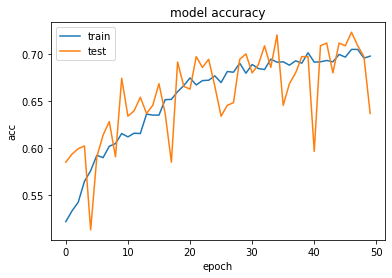

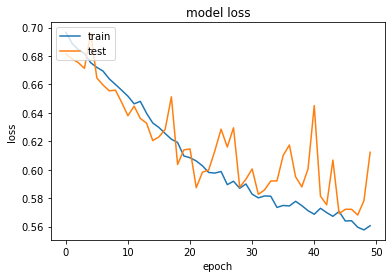

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [14]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
test_datagen.fit(X_test)

score = model.evaluate(test_datagen.flow(X_test, y_test, batch_size=batch_size), verbose=1)

  ...
    to  
  ['...']
174/174 [==============================] - 3s 18ms/step - loss: 0.5984 - accuracy: 0.6513
